In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

# Assume the FAERS data directory structure is similar to:
# /content/drive/My Drive/datasets/faers_2015Q1/
# /content/drive/My Drive/datasets/faers_2015Q2/
# ...
# /content/drive/My Drive/datasets/faers_2024Q4/
# Each quarter contains DEMOxxQx.txt, DRUGxxQx.txt, REACxxQx.txt, INDIxxQx.txt, etc.

base_dir = "/content/drive/My Drive/datasets"
years = range(2015, 2025)  # 2015 ~ 2024
quarters = ["Q1", "Q2", "Q3", "Q4"]

# Lists to store merged DataFrames
all_drug_dfs = []
all_demo_dfs = []
all_reac_dfs = []
all_indi_dfs = []

def extract_year_quarter_from_path(folder_name):
    """
    Extracts year and quarter from folder_name assuming it is in the format 'faers_2015Q1'.
    """
    match = re.search(r'faers_(\d{4})(Q\d)', folder_name)
    if match:
        year_str = match.group(1)
        quarter_str = match.group(2)
        return int(year_str), quarter_str
    else:
        return None, None

# 1. Iterate through all years and quarters to read DRUG, DEMO, REAC, INDI data
for year in years:
    for q in quarters:
        folder_name = f"faers_{year}{q}"  # e.g., faers_2015Q1
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            # Folder does not exist, possibly because the data has not been updated yet, skip
            continue

        # Extract year/quarter labels
        y, qn = extract_year_quarter_from_path(folder_name)

        # Construct file paths
        # This example processes only DRUG, DEMO, REAC, INDI. If OUTC, RPSR, THER are needed, extend accordingly.
        drug_file = os.path.join(folder_path, f"DRUG{str(year)[2:]}{q}.txt")
        demo_file = os.path.join(folder_path, f"DEMO{str(year)[2:]}{q}.txt")
        reac_file = os.path.join(folder_path, f"REAC{str(year)[2:]}{q}.txt")
        indi_file = os.path.join(folder_path, f"INDI{str(year)[2:]}{q}.txt")

        # Read files if they exist
        if os.path.isfile(drug_file):
            df_drug = pd.read_csv(drug_file, sep='$', low_memory=False)
            df_drug['year'] = y
            df_drug['quarter'] = qn
            all_drug_dfs.append(df_drug)

        if os.path.isfile(demo_file):
            df_demo = pd.read_csv(demo_file, sep='$', low_memory=False)
            df_demo['year'] = y
            df_demo['quarter'] = qn
            all_demo_dfs.append(df_demo)

        if os.path.isfile(reac_file):
            df_reac = pd.read_csv(reac_file, sep='$', low_memory=False)
            df_reac['year'] = y
            df_reac['quarter'] = qn
            all_reac_dfs.append(df_reac)

        if os.path.isfile(indi_file):
            df_indi = pd.read_csv(indi_file, sep='$', low_memory=False)
            df_indi['year'] = y
            df_indi['quarter'] = qn
            all_indi_dfs.append(df_indi)

# Merge all quarterly data
drug_df = pd.concat(all_drug_dfs, ignore_index=True)
demo_df = pd.concat(all_demo_dfs, ignore_index=True)
reac_df = pd.concat(all_reac_dfs, ignore_index=True)
indi_df = pd.concat(all_indi_dfs, ignore_index=True)

print("drug_df shape:", drug_df.shape)
print("demo_df shape:", demo_df.shape)
print("reac_df shape:", reac_df.shape)
print("indi_df shape:", indi_df.shape)

# 2. Filter records containing prednisolone (example: drugname in drug_df)
drug_df['drugname_clean'] = drug_df['drugname'].str.upper().fillna("")
prednisolone_df = drug_df[drug_df['drugname_clean'].str.contains("PREDNISOLONE", na=False)]

# 3. Classification into 5 categories
def classify_pred_methyl_5cat(drugname):
    name = drugname.upper()
    if re.search(r'[\\/;]', name):
        return "COMBINATION"
    if "METHYLPREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "SUCCINATE", "ACEPONATE", "HEMISUCCINATE"]):
            return "METHYLPREDNISOLONE_DERIVATIVE"
        else:
            return "METHYLPREDNISOLONE"
    elif "PREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "STEAGLATE", "VALERATE", "SUCCINATE", "METASULFO", "METAZOATE"]):
            return "PREDNISOLONE_DERIVATIVE"
        else:
            return "PREDNISOLONE"
    else:
        return np.nan

prednisolone_df['major_class_5cat'] = prednisolone_df['drugname_clean'].apply(classify_pred_methyl_5cat)

# 4. Merge demo/reac/indi data
# 4.1 Filter demo, reac, indi based on caseid
caseids = prednisolone_df['caseid'].unique()
demo_sub = demo_df[demo_df['caseid'].isin(caseids)].copy()
reac_sub = reac_df[reac_df['caseid'].isin(caseids)].copy()
indi_sub = indi_df[indi_df['caseid'].isin(caseids)].copy()

# 4.2 Keep necessary columns
demo_keep = ['primaryid','caseid','year','quarter','age','sex','rept_dt']
reac_keep = ['primaryid','caseid','year','quarter','pt']
indi_keep = ['primaryid','caseid','year','quarter','indi_pt']

demo_sub = demo_sub[demo_keep]
reac_sub = reac_sub[reac_keep]
indi_sub = indi_sub[indi_keep]

# 4.3 Merge datasets
pred_keep = ['primaryid','caseid','year','quarter','drug_seq','role_cod','drugname','drugname_clean','major_class_5cat']
pred_sub = prednisolone_df[pred_keep]

merged_demo_drug = pd.merge(demo_sub, pred_sub, on=['primaryid','caseid','year','quarter'], how='left')
merged_drug_reac = pd.merge(merged_demo_drug, reac_sub, on=['primaryid','caseid','year','quarter'], how='left')
final_merged = pd.merge(merged_drug_reac, indi_sub, on=['primaryid','caseid','year','quarter'], how='left')

# 5. Remove duplicates and group
def join_unique(x):
    return "; ".join(sorted(set(x.dropna())))

final_one_row = final_merged.groupby(['year','quarter','caseid'], as_index=False).agg({
    'age': 'first',
    'sex': 'first',
    'drugname_clean': 'first',
    'major_class_5cat': 'first',
    'pt': join_unique,
    'indi_pt': join_unique
})

print("final_one_row shape:", final_one_row.shape)
print(final_one_row.head(10))


Mounted at /content/drive


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xad in position 126098: invalid start byte

In [3]:
# 1.Read the datasets
from google.colab import drive
drive.mount('/content/drive')
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory for FAERS datasets
base_dir = "/content/drive/My Drive/datasets"

# Only process years 2020–2024 for Q4
years = range(2020, 2025)
quarter = "Q4"

# Lists to store DataFrames for each file type
all_drug_dfs = []
all_demo_dfs = []
all_reac_dfs = []
all_indi_dfs = []

def extract_year_quarter(folder_name):
    """
    Extract year and quarter from folder name, e.g., 'faers_2020Q4'
    """
    match = re.search(r'faers_(\d{4})(Q\d)', folder_name)
    if match:
        return int(match.group(1)), match.group(2)
    return None, None

# Loop through the specified years for Q4
for year in years:
    folder_name = f"faers_{year}{quarter}"  # e.g., "faers_2020Q4"
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    # Extract year and quarter label from folder name
    y, q_label = extract_year_quarter(folder_name)

    # Construct file paths for DRUG, DEMO, REAC, and INDI files
    # (Assuming file naming follows pattern like DRUG20Q4.txt, DEMO20Q4.txt, etc.)
    year_str = str(year)[2:]  # e.g., "20" for 2020
    drug_file = os.path.join(folder_path, f"DRUG{year_str}{quarter}.txt")
    demo_file = os.path.join(folder_path, f"DEMO{year_str}{quarter}.txt")
    reac_file = os.path.join(folder_path, f"REAC{year_str}{quarter}.txt")
    indi_file = os.path.join(folder_path, f"INDI{year_str}{quarter}.txt")

    # Read DRUG file if it exists
    if os.path.isfile(drug_file):
        df_drug = pd.read_csv(drug_file, sep='$', low_memory=False)
        df_drug['year'] = y
        df_drug['quarter'] = q_label
        all_drug_dfs.append(df_drug)
        print(f"Successfully loaded {drug_file} with shape {df_drug.shape}")
    else:
        print(f"File not found: {drug_file}")

    # Read DEMO file if it exists
    if os.path.isfile(demo_file):
        df_demo = pd.read_csv(demo_file, sep='$', low_memory=False)
        df_demo['year'] = y
        df_demo['quarter'] = q_label
        all_demo_dfs.append(df_demo)
        print(f"Successfully loaded {demo_file} with shape {df_demo.shape}")
    else:
        print(f"File not found: {demo_file}")

    # Read REAC file if it exists
    if os.path.isfile(reac_file):
        df_reac = pd.read_csv(reac_file, sep='$', low_memory=False)
        df_reac['year'] = y
        df_reac['quarter'] = q_label
        all_reac_dfs.append(df_reac)
        print(f"Successfully loaded {reac_file} with shape {df_reac.shape}")
    else:
        print(f"File not found: {reac_file}")

    # Read INDI file if it exists
    if os.path.isfile(indi_file):
        df_indi = pd.read_csv(indi_file, sep='$', low_memory=False)
        df_indi['year'] = y
        df_indi['quarter'] = q_label
        all_indi_dfs.append(df_indi)
        print(f"Successfully loaded {indi_file} with shape {df_indi.shape}")
    else:
        print(f"File not found: {indi_file}")

# Concatenate data for each type (Q4 only, from 2020–2024)
if all_drug_dfs:
    drug_df = pd.concat(all_drug_dfs, ignore_index=True)
else:
    drug_df = pd.DataFrame()
if all_demo_dfs:
    demo_df = pd.concat(all_demo_dfs, ignore_index=True)
else:
    demo_df = pd.DataFrame()
if all_reac_dfs:
    reac_df = pd.concat(all_reac_dfs, ignore_index=True)
else:
    reac_df = pd.DataFrame()
if all_indi_dfs:
    indi_df = pd.concat(all_indi_dfs, ignore_index=True)
else:
    indi_df = pd.DataFrame()

print("Combined drug_df shape:", drug_df.shape)
print("Combined demo_df shape:", demo_df.shape)
print("Combined reac_df shape:", reac_df.shape)
print("Combined indi_df shape:", indi_df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded /content/drive/My Drive/datasets/faers_2020Q4/DRUG20Q4.txt with shape (1918927, 22)
Successfully loaded /content/drive/My Drive/datasets/faers_2020Q4/DEMO20Q4.txt with shape (436148, 27)
Successfully loaded /content/drive/My Drive/datasets/faers_2020Q4/REAC20Q4.txt with shape (1522657, 6)
Successfully loaded /content/drive/My Drive/datasets/faers_2020Q4/INDI20Q4.txt with shape (1297446, 6)
Successfully loaded /content/drive/My Drive/datasets/faers_2021Q4/DRUG21Q4.txt with shape (1778675, 22)
Successfully loaded /content/drive/My Drive/datasets/faers_2021Q4/DEMO21Q4.txt with shape (412542, 27)
Successfully loaded /content/drive/My Drive/datasets/faers_2021Q4/REAC21Q4.txt with shape (1355734, 6)
Successfully loaded /content/drive/My Drive/datasets/faers_2021Q4/INDI21Q4.txt with shape (1234766, 6)
Successfully loaded /content/drive/My Drive/d

In [4]:
# 2. Filter for Prednisolone records and classify them into 5 categories

drug_df['drugname_clean'] = drug_df['drugname'].str.upper().fillna("")

# Filter rows containing 'PREDNISOLONE'
prednisolone_drugs = drug_df[drug_df['drugname_clean'].str.contains("PREDNISOLONE", na=False)]
prednisolone_df = prednisolone_drugs.copy()

def classify_pred_methyl_5cat(drugname):
    """
    Classify drug names into 5 categories:
    1) PREDNISOLONE (base)
    2) PREDNISOLONE_DERIVATIVE
    3) METHYLPREDNISOLONE (base)
    4) METHYLPREDNISOLONE_DERIVATIVE
    5) COMBINATION (if multiple active ingredients are present)
    """
    name = drugname.upper()
    if re.search(r'[\\/;]', name):
        return "COMBINATION"
    if "METHYLPREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "SUCCINATE", "ACEPONATE", "HEMISUCCINATE"]):
            return "METHYLPREDNISOLONE_DERIVATIVE"
        else:
            return "METHYLPREDNISOLONE"
    elif "PREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "STEAGLATE", "VALERATE", "SUCCINATE", "METASULFO", "METAZOATE"]):
            return "PREDNISOLONE_DERIVATIVE"
        else:
            return "PREDNISOLONE"
    else:
        return np.nan

prednisolone_df['major_class_5cat'] = prednisolone_df['drugname_clean'].apply(classify_pred_methyl_5cat)
print("Classification counts (5 categories):")
print(prednisolone_df['major_class_5cat'].value_counts(dropna=False))

Classification counts (5 categories):
major_class_5cat
PREDNISOLONE                     36817
METHYLPREDNISOLONE               26133
METHYLPREDNISOLONE_DERIVATIVE     7507
PREDNISOLONE_DERIVATIVE           2034
COMBINATION                        238
Name: count, dtype: int64


In [5]:
# 3. Merge with DEMO, REAC, and INDI datasets based on caseid
# Get unique caseids from the prednisolone subset
caseids = prednisolone_df['caseid'].unique()

demo_sub = demo_df[demo_df['caseid'].isin(caseids)].copy()
reac_sub = reac_df[reac_df['caseid'].isin(caseids)].copy()
indi_sub = indi_df[indi_df['caseid'].isin(caseids)].copy()

# Keep necessary columns
demo_keep = ['primaryid', 'caseid', 'year', 'quarter', 'age', 'sex']
reac_keep = ['primaryid', 'caseid', 'year', 'quarter', 'pt']
indi_keep = ['primaryid', 'caseid', 'year', 'quarter', 'indi_pt']
pred_keep = ['primaryid', 'caseid', 'year', 'quarter', 'drug_seq', 'role_cod', 'drugname', 'drugname_clean', 'major_class_5cat']

demo_sub = demo_sub[demo_keep]
reac_sub = reac_sub[reac_keep]
indi_sub = indi_sub[indi_keep]
pred_sub = prednisolone_df[pred_keep]

# Merge the data on primaryid, caseid, year, and quarter
merged_demo_drug = pd.merge(demo_sub, pred_sub, on=['primaryid','caseid','year','quarter'], how='left')
merged_drug_reac = pd.merge(merged_demo_drug, reac_sub, on=['primaryid','caseid','year','quarter'], how='left')
final_merged = pd.merge(merged_drug_reac, indi_sub, on=['primaryid','caseid','year','quarter'], how='left')

print("Final merged DataFrame shape:", final_merged.shape)
print(final_merged.head(10))

Final merged DataFrame shape: (23481736, 13)
    primaryid    caseid  year quarter   age sex  drug_seq role_cod  \
0  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
1  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
2  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
3  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
4  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
5  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
6  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
7  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
8  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
9  1005528543  10055285  2020      Q4  57.0   F      33.0        C   

        drugname drugname_clean major_class_5cat              pt  \
0  PREDNISOLONE.  PREDNISOLONE.     PREDNISOLONE  Abdominal pain   
1  PREDNISOLONE.  PREDNISOLONE.     PREDNISOLONE

In [6]:
# 4. Aggregate records: one row per (year, quarter, caseid)
def join_unique(x):
    return "; ".join(sorted(set(x.dropna())))

final_one_row = final_merged.groupby(['year','quarter','caseid'], as_index=False).agg({
    'age': 'first',
    'sex': 'first',
    'drugname_clean': 'first',
    'major_class_5cat': 'first',
    'pt': join_unique,
    'indi_pt': join_unique
})

print("Aggregated DataFrame shape:", final_one_row.shape)
print(final_one_row.head(10))

Aggregated DataFrame shape: (45580, 9)
   year quarter   caseid   age sex       drugname_clean    major_class_5cat  \
0  2020      Q4  6715981  37.0   M        PREDNISOLONE.        PREDNISOLONE   
1  2020      Q4  6798099  44.0   M        PREDNISOLONE.        PREDNISOLONE   
2  2020      Q4  7096069  45.0   M        PREDNISOLONE.        PREDNISOLONE   
3  2020      Q4  7740732  30.0   F  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   
4  2020      Q4  7796415  64.0   M  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   
5  2020      Q4  7928220  63.0   F        PREDNISOLONE.        PREDNISOLONE   
6  2020      Q4  8220672  68.0   M        PREDNISOLONE.        PREDNISOLONE   
7  2020      Q4  8221889  68.0   M        PREDNISOLONE.        PREDNISOLONE   
8  2020      Q4  8497662  67.0   F  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   
9  2020      Q4  8671723  60.0   F  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   

                                                  pt  \
0                                  

<ipython-input-7-1d44e57bf342>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='report_count', data=yearly_counts, palette="Blues_d")


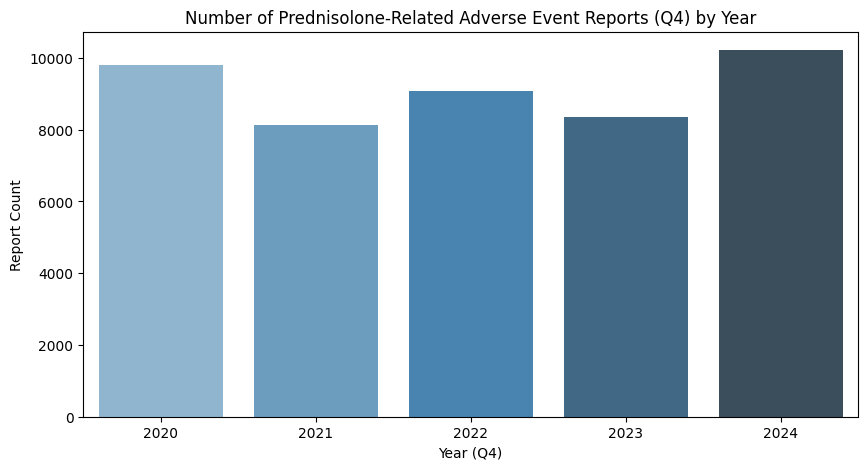

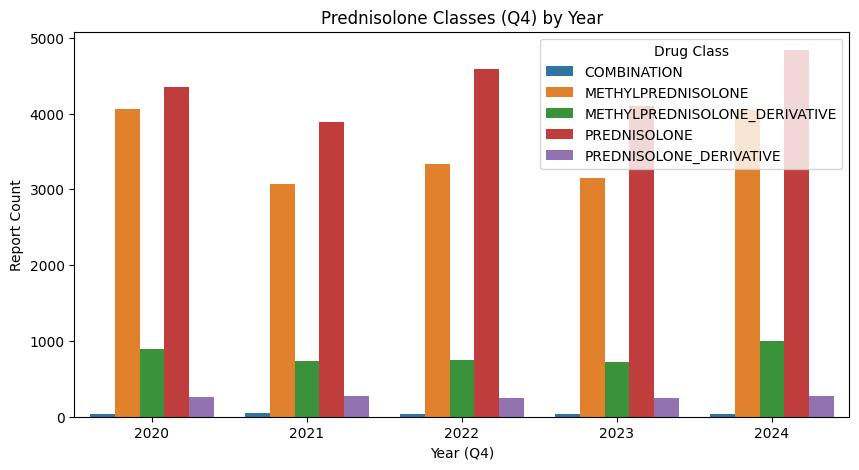

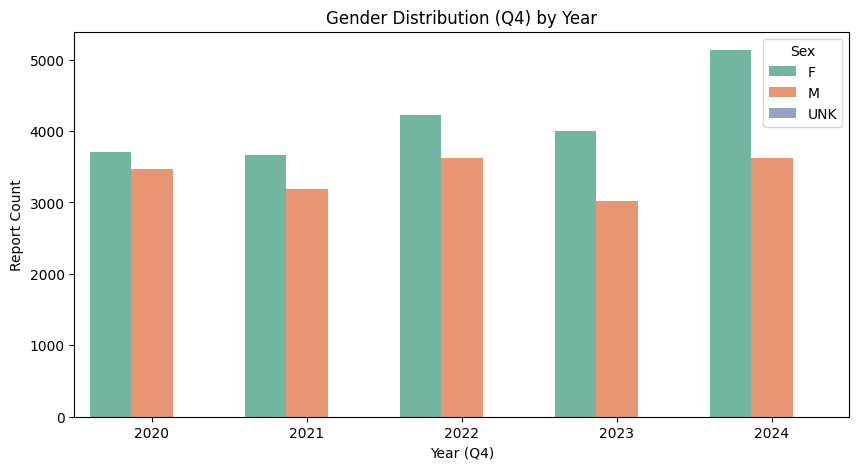

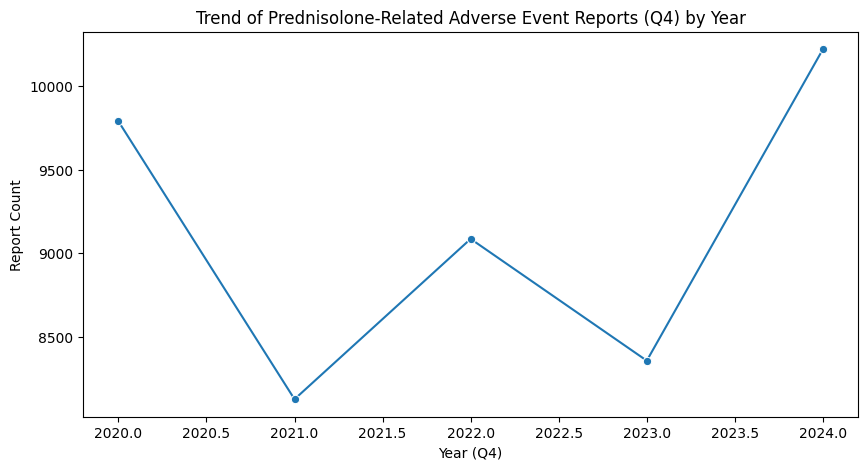

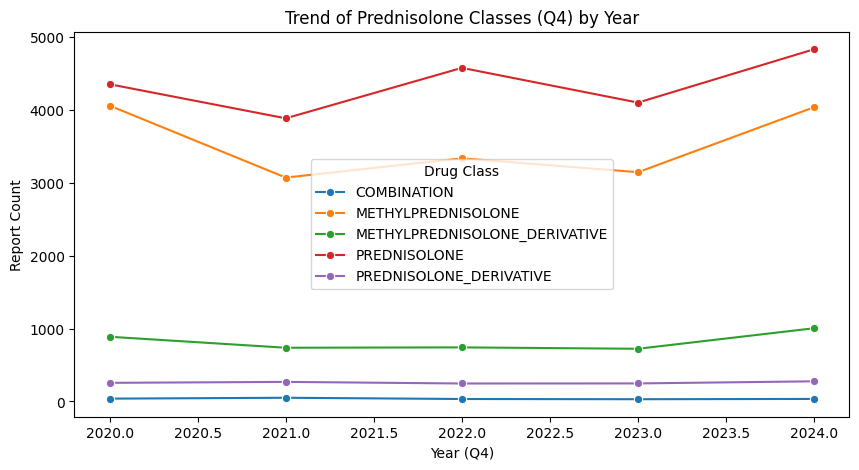

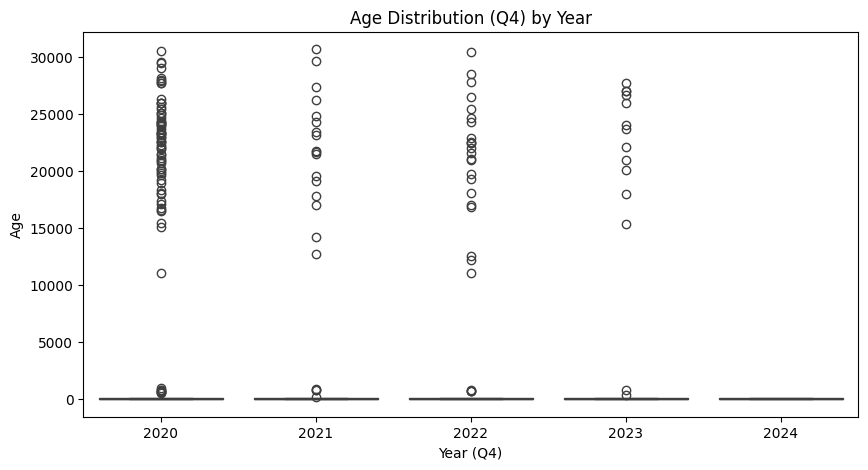

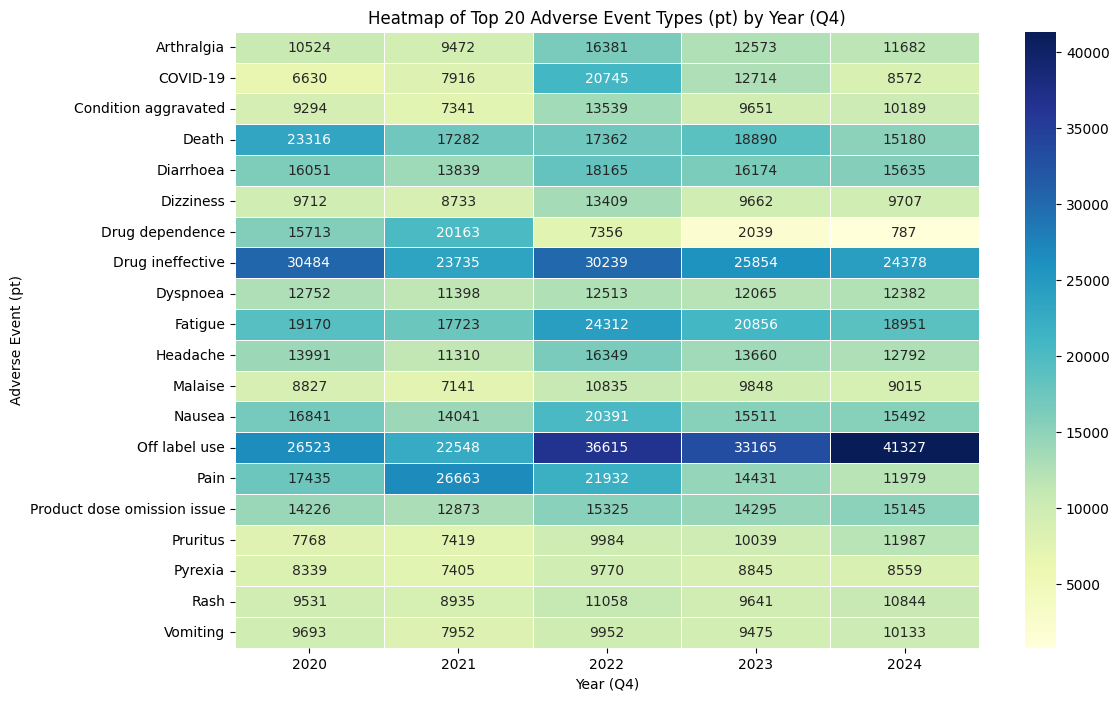

In [7]:
# 5. Visualize Q4 data for 2020–2024

# Count of adverse event reports by year (Q4 only)
yearly_counts = final_one_row.groupby('year').size().reset_index(name='report_count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='report_count', data=yearly_counts, palette="Blues_d")
plt.title("Number of Prednisolone-Related Adverse Event Reports (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.show()

# Distribution of the 5 classes across years (Q4 only)
class_year_counts = final_one_row.groupby(['year', 'major_class_5cat']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='major_class_5cat', data=class_year_counts)
plt.title("Prednisolone Classes (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

# Gender distribution by year (Q4 only)
year_sex_counts = final_one_row.groupby(['year', 'sex']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='sex', data=year_sex_counts, palette="Set2")
plt.title("Gender Distribution (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.legend(title="Sex")
plt.show()
# Line Chart: Trend of total adverse event reports by year (Q4)
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='report_count', data=yearly_counts, marker="o", sort=True)
plt.title("Trend of Prednisolone-Related Adverse Event Reports (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.show()

# Line Chart: Trend of each drug class across years
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='count', hue='major_class_5cat', data=class_year_counts, marker="o")
plt.title("Trend of Prednisolone Classes (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

# Boxplot: Age distribution by year (if age is numeric)
plt.figure(figsize=(10, 5))
sns.boxplot(x='year', y='age', data=final_one_row)
plt.title("Age Distribution (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Age")
plt.show()

# Heatmap: Frequency of top 20 adverse event types (pt) by year in Q4
# Filter reac_df for years 2020-2024 and Q4
reac_q4 = reac_df[(reac_df['year'].isin(years)) & (reac_df['quarter'] == quarter)]
# Compute top 20 most common pt values
top20_pt = reac_q4['pt'].value_counts().head(20).index.tolist()
filtered_reac = reac_q4[reac_q4['pt'].isin(top20_pt)]
pt_year_pivot = filtered_reac.pivot_table(index='pt', columns='year', values='primaryid', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pt_year_pivot, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)
plt.title("Heatmap of Top 20 Adverse Event Types (pt) by Year (Q4)")
plt.xlabel("Year (Q4)")
plt.ylabel("Adverse Event (pt)")
plt.show()